# 1. 데이터로더 및 모델 불러오기

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import time
import random
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Make Valid Data Set
class Dataset_Valid(Dataset):
    def __init__(self,flag = 'valid' ,size=None,
                 features='S', data_path='data2015.csv',
                 target='MW', timeenc=0, freq='5min', cols=None, variable = 3):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 12 * 24 * 14
            self.label_len = 12 *24 * 7
            self.pred_len = 12 * 6
        else:
            self.seq_len = size[0]
            self.label_len = 12 * 24 * 14
            self.pred_len = size[2]
        # init
        assert flag in ['val']

        self.features = features
        self.target = target

        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.data_path = data_path
        self.flag = flag
        self.variable = variable
        self.__read_data__()

    def __read_data__(self):
        df_raw = pd.read_csv(self.data_path)
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols = self.cols.copy()
        else:
            cols = list(df_raw.columns)
            self.cols = cols.copy()
            cols.remove('date')
        if self.features == 'S':
            cols.remove(self.target)
        
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)
        
        # 다변량 시계열 예측이라면 지정한 변수만큼만을 사용 or 단변량 시계열 예측이면 target(MW)만을 사용.
        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:self.variable]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        data = df_data.values
        
        # Valid set 기간 명시
        tmp_stamp = df_raw[['date']][(-2016 * 3) - self.seq_len : -2016]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)

        pred_dates = pd.date_range(tmp_stamp.date.values[self.seq_len], periods=tmp_stamp.shape[0]- self.seq_len, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values)
        self.future_dates = list(pred_dates)
        
        df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
        df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
        df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
        df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
        df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
        df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 5)
        data_stamp = df_stamp.drop(['date'], 1).values

        # 지정한 Valid set 기간에서 seqeunce 길이만큼 더 이전의 
        self.data_x = data[(-2016 * 3) - self.seq_len : -2016]
        self.data_y = data[(-2016 * 3) - self.seq_len : -2016]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index * self.pred_len 
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return self.label_len // self.pred_len

# Make Test Dataset
class Dataset_Test(Dataset):
    def __init__(self,flag = 'test' ,size=None,
                 features='S', data_path='data2015.csv',
                 target='MW', timeenc=0, freq='5min', cols=None, variable = 3):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 12 * 24 * 14
            self.label_len = 12 *24 * 7
            self.pred_len = 12 * 6
        else:
            self.seq_len = size[0]
            self.label_len = 12 *24 * 7
            self.pred_len = size[2]
        # init
        assert flag in ['test']

        self.features = features
        self.target = target

        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.data_path = data_path
        self.flag = flag
        self.variable = variable
        self.__read_data__()

    def __read_data__(self):
        df_raw = pd.read_csv(self.data_path)
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols = self.cols.copy()
        else:
            cols = list(df_raw.columns)
            self.cols = cols.copy()
            cols.remove('date')
        if self.features == 'S':
            cols.remove(self.target)
        
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:self.variable]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        data = df_data.values

        tmp_stamp = df_raw[['date']][-2016 - self.seq_len:]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)

        pred_dates = pd.date_range(tmp_stamp.date.values[self.seq_len], periods=tmp_stamp.shape[0]- self.seq_len, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values)
        self.future_dates = list(pred_dates)
        
        df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
        df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
        df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
        df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
        df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
        df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 5)
        data_stamp = df_stamp.drop(['date'], 1).values



        self.data_x = data[-2016 - self.seq_len:]
        self.data_y = data[-2016 - self.seq_len:]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index * self.pred_len 
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return self.label_len // self.pred_len


In [2]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        # (batch,seq,channel)
        
        # padding을 해주어 이동 평균 이후와 이전의 sequence 길이를 동일하게 만들어줌.
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1) # 구간의 맨 처음 시점의 값과, 마지막 시점의 값을 raw data에 붙여줌.
        x = self.avg(x.permute(0, 2, 1)) # avgpool은 1차원 축을 따라 동작
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x) # 이동 평균으로 얻은 추세데이터
        res = x - moving_mean # 원본 데이터에서 추세를 제거한 잔차 데이터
        return res, moving_mean # 잔차 데이터와 , 추세 데이터

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len,pred_len,window_size):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        kernel_size = window_size
        self.decompsition = series_decomp(kernel_size)
        
        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

        # Use this two lines if you want to visualize the weights
        # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        
        seasonal_output = self.Linear_Seasonal(seasonal_init) # 주기에 대한 output과
        trend_output = self.Linear_Trend(trend_init) # 추세에 대한 output 

        x = seasonal_output + trend_output # 가법으로 진행.
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [3]:
# Model Evaluate

def vali(model,checkpoint_path,vali_data, vali_loader, criterion,epoch,flag,feature,name):
    total_loss = []
    total_mape = []
    preds=[]
        
    features = feature
    
    # 학습된 모델 가중치 load
    model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'))
    model.eval()
    
    # inference time 측정위한 start 변수 생성.
    start = time.time()
    
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(tqdm(vali_loader)):
            batch_x = batch_x.float()
            batch_y = batch_y.float()
            
            batch_x_mark = batch_x_mark.float()
            batch_y_mark = batch_y_mark.float()

            # encoder - decoder
            outputs = model(batch_x)
            
            pred = outputs
            true = batch_y
            preds.append(pred.numpy())
            loss = criterion(pred, true)
            
            # 만약 기상데이터가 포함되었다면 MAPE 계산시 MW만을 계산하도록 함.
            if features == "M":
                 mape,_ = MAPE(pred.numpy()[:,:,0], true.numpy()[:,:,0])
            else:
                 mape,_  = MAPE(pred.numpy(), true.numpy())

            total_mape.append(mape)                                   
            total_loss.append(loss)
            
    # Inference Speed 확인.
    print(f"Inference Speed (Latency) : {(time.time() - start)*1000/(i+1):.5f} ms")
    
    # result save
    folder_path = './results/' + name +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    np.save(folder_path + flag + '_real_prediction.npy', np.array(preds))

    total_loss = np.average(total_loss)
    total_mape = np.average(total_mape)
    
    return total_loss,total_mape,preds

#### - 평가 함수

In [4]:
# Metric

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true)) * 100 , np.std(np.abs((pred - true) / true))

def MAE(pred, true):
    return np.mean(np.abs(pred - true)) , np.std(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2) , np.std((pred - true) ** 2)

In [5]:
# Valid Dataset, Valid DataLoader 만들기

valid_dataset = Dataset_Valid(data_path = './data/data2015.csv',
                              flag = 'val',
                              size = [6048,4032,72],
                              features = 'M',
                              target = 'MW',
                              freq = '5min',
                              variable = 5
)

valid_loader = DataLoader(valid_dataset,
                           batch_size = 1,
                           shuffle = False,
                           num_workers = 0,
                           drop_last = False
)

In [6]:
# Test Dataset, Test DataLoader 만들기

test_dataset = Dataset_Test(data_path = './data/data2015.csv',
                              flag = 'test',
                              size = [6048,2016,72],
                              features = 'M',
                              target = 'MW',
                              freq = '5min',
                              variable = 5
)

test_loader = DataLoader(test_dataset,
                           batch_size = 1,
                           shuffle = False,
                           num_workers = 0,
                           drop_last = False
)

# 2. (실험과정) 1주Input -> 1주Output 모델, 2주Input -> 1주Output 모델 추론 및 평가

In [7]:
# 정답값 불러오기
data_2015 = pd.read_csv('./data/data2015.csv')
target = data_2015.iloc[-2016:]
valid  = data_2015.iloc[-2016*3 : -2016]

In [8]:
# 1week -> 1week
# Valid Dataset, Valid DataLoader 만들기

valid_2016_dataset = Dataset_Valid(data_path = './data/data2015.csv',
                              flag = 'val',
                              size = [2016,4032,2016],
                              features = 'S',
                              target = 'MW',
                              freq = '5min',
)

valid_2016_loader = DataLoader(valid_2016_dataset,
                           batch_size = 1,
                           shuffle = False,
                           num_workers = 0,
                           drop_last = False
)

In [9]:
# 2week -> 1week
# Valid Dataset, Valid DataLoader 만들기

valid_4032_dataset = Dataset_Valid(data_path = './data/data2015.csv',
                              flag = 'val',
                              size = [4032,4032,2016],
                              features = 'S',
                              target = 'MW',
                              freq = '5min',
)

valid_4032_loader = DataLoader(valid_4032_dataset,
                           batch_size = 1,
                           shuffle = False,
                           num_workers = 0,
                           drop_last = False
)

In [10]:
# 1Week -> 1Week Prediction
# seed 고정
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

model_2016 = DLinear(2016,2016,11)  # 1week -> 1week model
model_4032 = DLinear(4032,2016,11)  # 2week -> 1week model

criterion = nn.L1Loss()
epoch = 30

checkpoint_2016 = './DLinear/checkpoints/2019_uni_2016_2016_DLinear_Train_L1/checkpoint_30.pth'
checkpoint_4032 = './DLinear/checkpoints/2019_uni_4032_2016_DLinear_Train_L1/checkpoint_30.pth'


# 1week , 2week 각각의 valid loss, mape, prediction 생성
valid_2016_loss, valid_2016_mape, valid_2016_preds = vali(model_2016,checkpoint_2016,valid_2016_dataset,valid_2016_loader,criterion,epoch,'valid',"M",'1주_input_1주_output')
valid_4032_loss, valid_4032_mape, valid_4032_preds = vali(model_4032,checkpoint_4032,valid_4032_dataset,valid_4032_loader,criterion,epoch,'valid',"M",'2주_input_1주_output')


print(f'1Week -> 1Week Valid_Loss : {valid_2016_loss} | Valid_MAPE : {valid_2016_mape}',end = '\n')
print(f'2Week -> 1Week Valid_Loss : {valid_4032_loss} | Valid_MAPE : {valid_4032_mape}',end = '\n')


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 341.53it/s]


Inference Speed (Latency) : 7.35319 ms


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 361.27it/s]

Inference Speed (Latency) : 3.35598 ms
1Week -> 1Week Valid_Loss : 2807.806396484375 | Valid_MAPE : 4.536600224673748
2Week -> 1Week Valid_Loss : 2723.126953125 | Valid_MAPE : 4.433676041662693


<Figure size 1440x720 with 0 Axes>

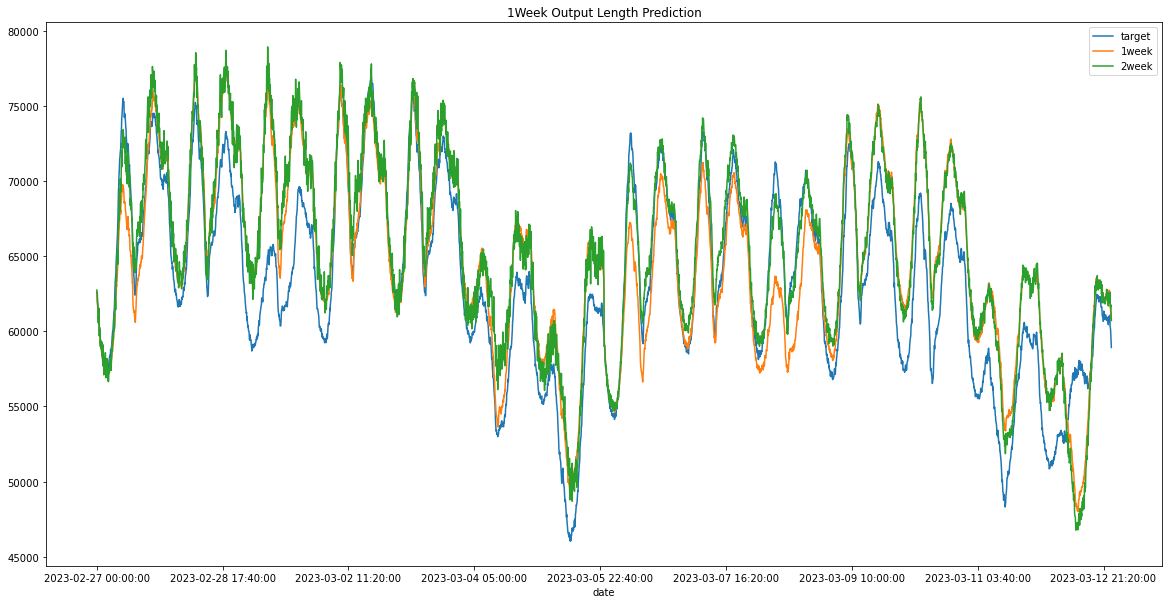

In [11]:
valid_2019_2016_2016 = np.load('./results/1주_input_1주_output/valid_real_prediction.npy').ravel()
valid_2019_4032_2016 = np.load('./results/2주_input_1주_output/valid_real_prediction.npy').ravel()

plt.figure(figsize = (20,10))
valid.plot('date','MW',figsize=(20,10),label='target')
plt.plot(valid.date.values,valid_2019_2016_2016,label='1week')
plt.plot(valid.date.values,valid_2019_4032_2016,label='2week')
plt.legend()
plt.title('1Week Output Length Prediction')
plt.show()

In [12]:
print('----1Week Prediction MAPE----',end='\n')
print('1주 Input & 1주 Output MAPE : ',MAPE(valid_2019_2016_2016,valid.MW.values)[0])
print('2주 Input & 1주 Output MAPE:' ,MAPE(valid_2019_4032_2016,valid.MW.values)[0],end='\n')


----1Week Prediction MAPE----
1주 Input & 1주 Output MAPE :  4.536600155773814
2주 Input & 1주 Output MAPE: 4.433676147662575


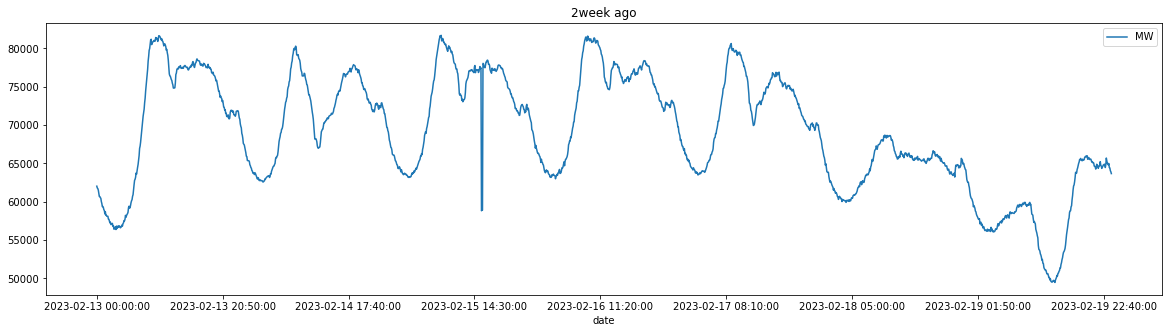

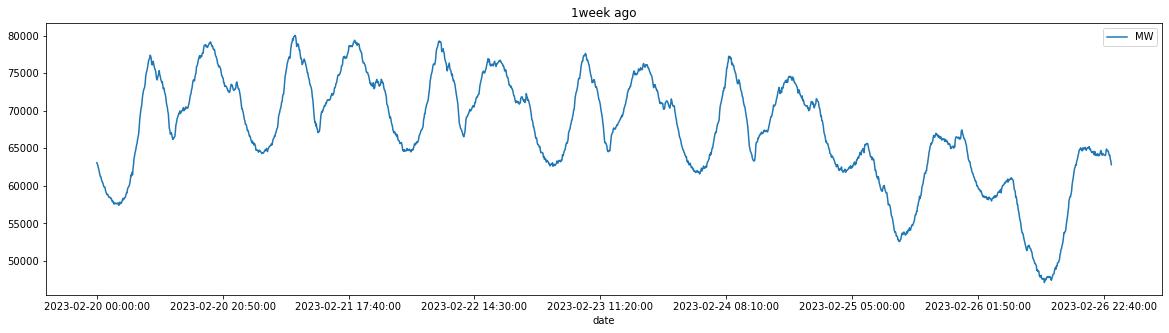

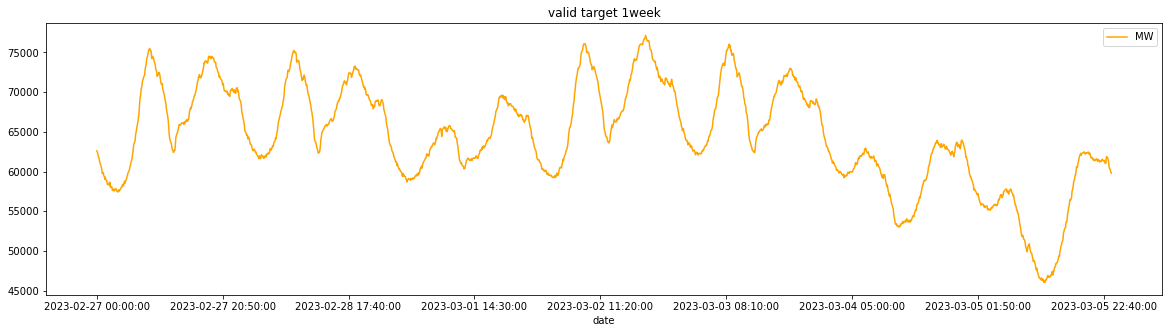

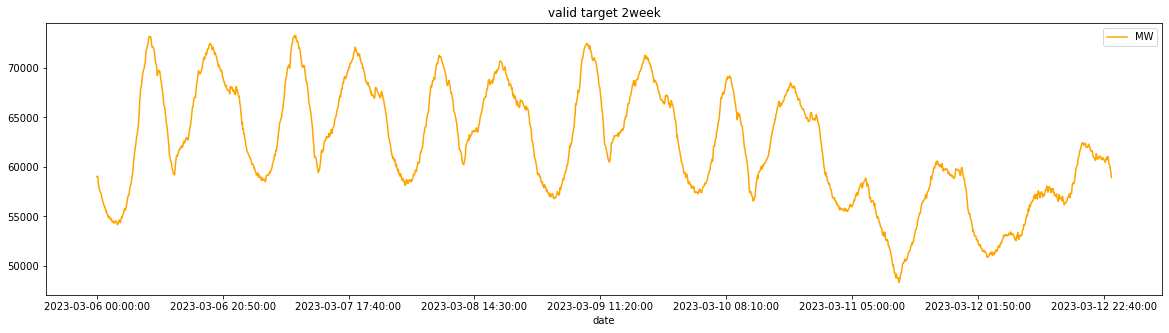

In [13]:
# Input 그래프와 정답값의 추세 차이 확인. 파란색은 Input , 노란색은 Target이다.
## 정답값의 3/12 일요일이 Input의 일요일 부분과 평소와는 다른 패턴을 보인다.

title_name = ['2week ago', '1week ago','valid target 1week', 'valid target 2week']

for i in range(4):
    if i >= 2:
        data_2015.iloc[-2016*(5-i):-2016*(4-i)].plot('date','MW',figsize=(20,5),color =  'orange')
    else:
        data_2015.iloc[-2016*(5-i):-2016*(4-i)].plot('date','MW',figsize=(20,5))
    plt.title(title_name[i])
    plt.show()

# 3. 최종모델을 사용한 검증 데이터셋 및 시험 데이터셋(대회 지정 분석 기간) 추론 및 평가

In [14]:
# seed 고정
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

model = DLinear(6048,72,11)
criterion = nn.L1Loss()
epoch = 30
checkpoint = './DLinear/checkpoints/2015_multi_hum_6048_72_DLinear_Train_L1/checkpoint_30.pth'


# Window CPU Inference Time 측정
valid_loss, valid_mape, valid_preds = vali(model,checkpoint,valid_dataset,valid_loader,criterion,epoch,'valid',"M",'최종모델')
test_loss, test_mape, test_preds = vali(model,checkpoint,test_dataset,test_loader,criterion,epoch,'test',"M",'최종모델')


print(f'Valid_Loss : {valid_loss} | Valid_MAPE : {valid_mape}',end = '\n')
print(f'Test_Loss : {test_loss} | Test_MAPE : {test_mape}')

100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 1290.42it/s]


Inference Speed (Latency) : 0.80125 ms


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1326.71it/s]

Inference Speed (Latency) : 0.79075 ms
Valid_Loss : 264.8270568847656 | Valid_MAPE : 1.6814303218520112
Test_Loss : 275.9801025390625 | Test_MAPE : 1.810932463766741


<Figure size 1440x720 with 0 Axes>

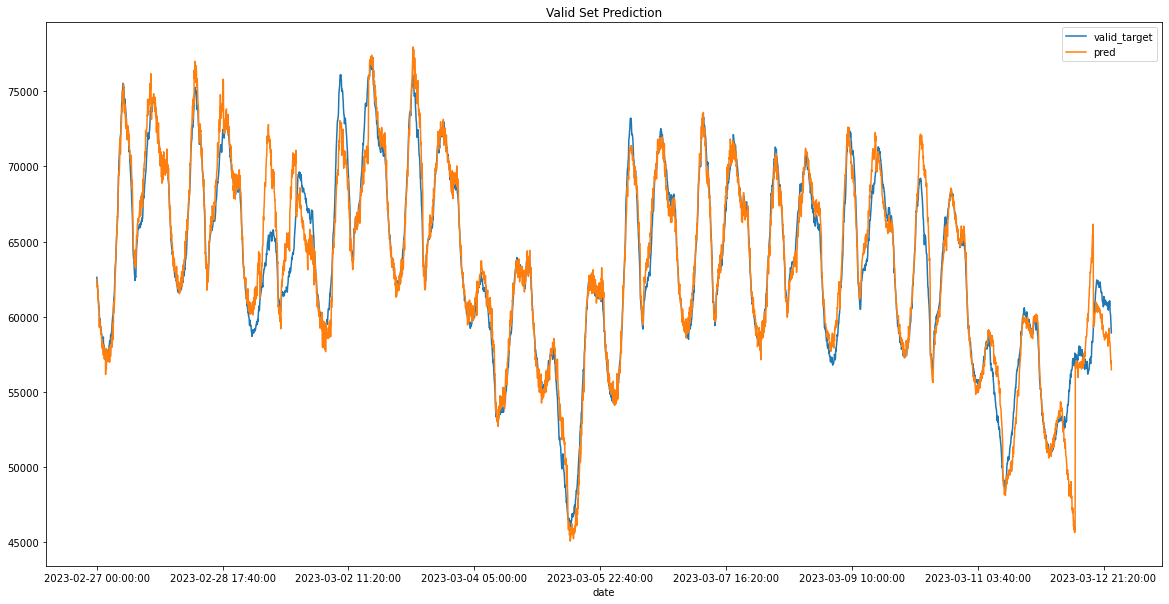

<Figure size 1440x720 with 0 Axes>

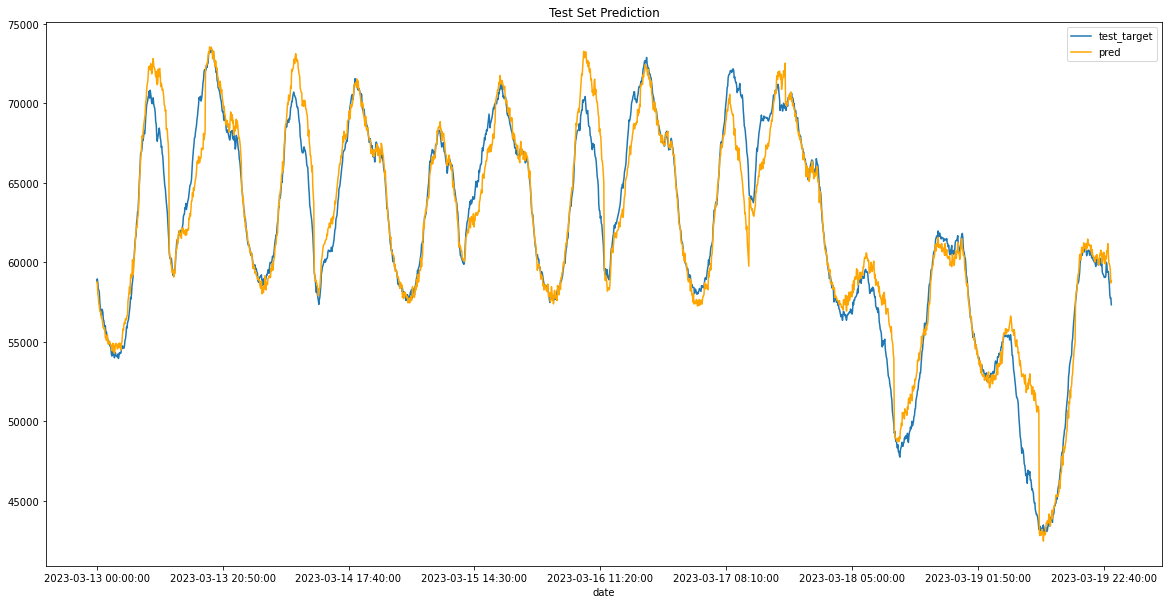

In [15]:
# 최종 모델 target값 예측 결과

test_2015_multi_hum_6048_72= np.load('./results/최종모델/test_real_prediction.npy')[:,:,:,0].ravel()
valid_2015_multi_hum_6048_72= np.load('./results/최종모델/valid_real_prediction.npy')[:,:,:,0].ravel()

# Valid Set Plot
plt.figure(figsize = (20,10))
valid.plot('date','MW',figsize=(20,10),label='valid_target')
plt.plot(valid.date.values,valid_2015_multi_hum_6048_72,label='pred')
plt.title('Valid Set Prediction')
plt.legend()
plt.show()



# Test Set Plot
plt.figure(figsize = (20,10))
target.plot('date','MW',figsize=(20,10),label='test_target')
plt.plot(target.date.values,test_2015_multi_hum_6048_72,label='pred',color = 'orange')
plt.legend()
plt.title('Test Set Prediction')
plt.show()

In [16]:
print('----최종 MAPE----')
print('Test MAPE : ',MAPE(test_2015_multi_hum_6048_72,target.MW.values)[0])
print('Valid MAPE:' ,MAPE(valid_2015_multi_hum_6048_72,valid.MW.values)[0],end='\n')
print()


----최종 MAPE----
Test MAPE :  1.8109325325075594
Valid MAPE: 1.6814302897366407



# 3. Weight Plot 생성 및 저장

In [17]:
# 모델이 어떤 시점에 영향을 크게 받았는지 확인할 수 있는 Weight Plot 그리기.

def weight_plot(path,folder_name):
    model_path = path
    weights = torch.load(model_path,map_location=torch.device('cpu'))
    weights_list = {}
    weights_list['seasonal'] = weights['Linear_Seasonal.weight'].numpy()
    weights_list['trend'] = weights['Linear_Trend.weight'].numpy()
    
    save_root = 'weights_plot'
    if not os.path.exists(os.path.join(save_root,folder_name)):
        os.makedirs(os.path.join(save_root,folder_name))

    for w_name,weight in weights_list.items():
        fig,ax=plt.subplots(figsize=(8,8))
        im=ax.imshow(weight,cmap='plasma_r')
        fig.colorbar(im,pad=0.03)
        plt.title(f'{folder_name} {w_name} Weight Plot')
        plt.xlabel('Input Sequence')
        plt.ylabel('Output Sequence')
        plt.savefig(os.path.join(save_root,folder_name,w_name + '.jpg'),dpi=500)
        plt.close()

In [18]:
# 1주 -> 1주 예측
weight_plot('./DLinear/checkpoints/2019_uni_2016_2016_DLinear_Train_L1/checkpoint_30.pth'
            , '1주_input_1주_output')

# 2주 -> 1주 예측
weight_plot('./DLinear/checkpoints/2019_uni_4032_2016_DLinear_Train_L1/checkpoint_30.pth'
            , '2주_input_1주_output')

# 3주 -> 6시간 예측
weight_plot('./DLinear/checkpoints/2015_multi_hum_6048_72_DLinear_Train_L1/checkpoint_30.pth'
            , 'Final Model')
